# Logistic Regression

Logistic Regression is a method for **Classification**. But what is classification ?

> In Machine Learning and Statistics, *Classification* is a problem of identifying to which of a set of categories a new observation belongs to based off of training data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory data analysis

### Verifying the data integrity

Using Seaborn's Heatmap, we can define if values are null or not.

It also helps us define which data we can use or not.

In [4]:
df.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


<AxesSubplot:>

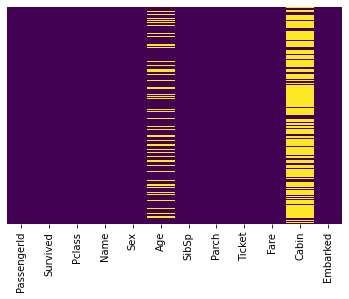

In [5]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

With this heatmap, we can tell that the cabin is not known in most cases. This means we will have to remove it from the features or transform it. For example with `Cabin Known` yes or no.

The age is missing in many cases as well, but maybe we can find a workaround.

<AxesSubplot:xlabel='Survived', ylabel='count'>

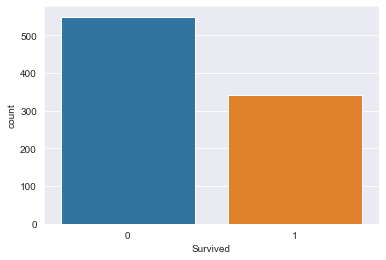

In [6]:
sns.set_style('darkgrid')
sns.countplot(data=df, x='Survived')

<AxesSubplot:xlabel='Survived', ylabel='count'>

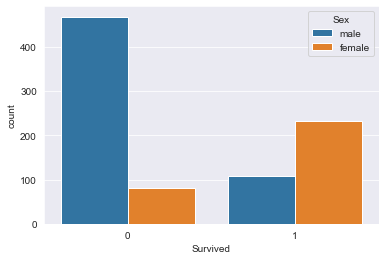

In [7]:
sns.countplot(data=df, x='Survived', hue='Sex')

We can see that the decesed are much more likely to be male than female.

<AxesSubplot:xlabel='Survived', ylabel='count'>

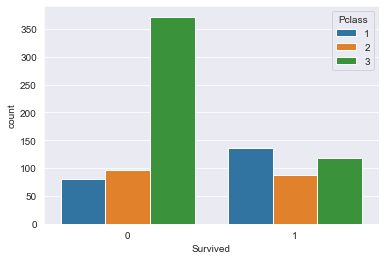

In [8]:
sns.countplot(data=df, x='Survived', hue='Pclass')

People who did not survive where overwhelmingly from the Third class.

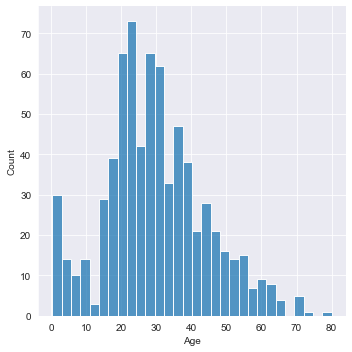

In [9]:
sns.displot(df['Age'].dropna(), bins=30)

This graph shows us that we have quite a few children,and then the bulk of the passengers were between 20 and 40.

<AxesSubplot:xlabel='SibSp', ylabel='count'>

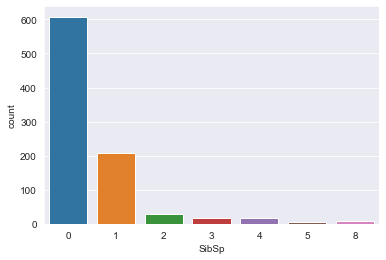

In [10]:
sns.countplot(data=df, x='SibSp')

We can see that there is mainly single people on board. These probably represent the single men in third class.

The Second most present situation is with 1 Sibling or Spouse. This situation is more likely to represent couples rather than a parent with a single child.

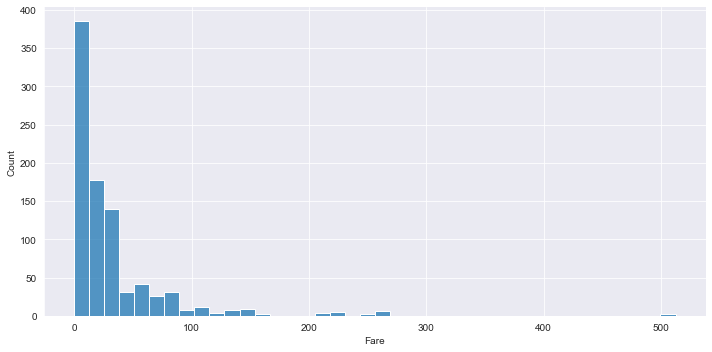

In [11]:
sns.displot(df['Fare'], bins=40, aspect=2)

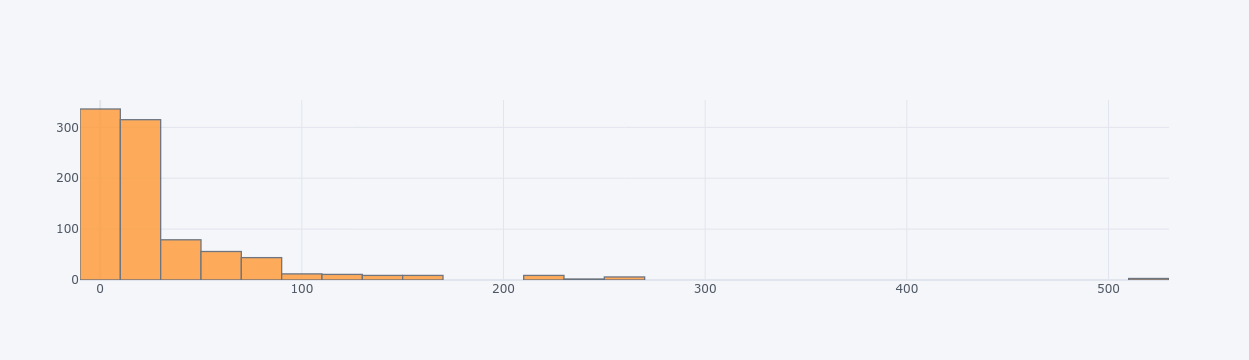

In [12]:
# The same graph can be ploted with Cufflinks
import cufflinks as cf

cf.go_offline()
df['Fare'].iplot(kind='hist', bins=40)

<AxesSubplot:xlabel='Survived', ylabel='count'>

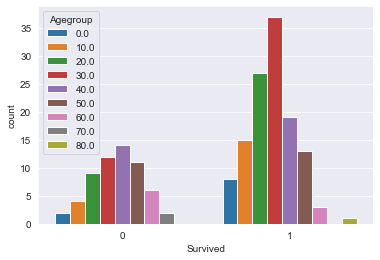

In [13]:
df['Agegroup'] = df['Age'].apply(lambda x: np.nan if np.isnan(x) else 10 * int(x / 10))
sns.countplot(data=df.dropna(), x='Survived', hue='Agegroup')

## Dealing with the missing data

The action we are trying to undertake is called ***preprocessing***. You can find extensive documentation on preprocessing [here](https://scikit-learn.org/stable/modules/preprocessing.html).

So what are we going to do?<br/>
Before, we saw that quite a few Ages were missing. Now how can we fill this up?
- We could use the mean of ages for each missing age
- We could also use the average age per passenger class


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

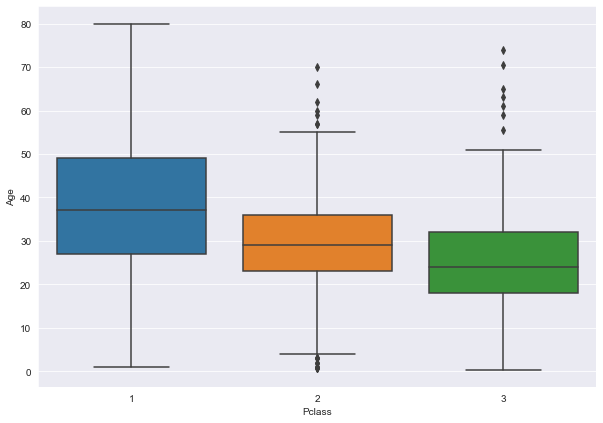

In [14]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Pclass', y='Age', data=df)

We can see that the first class passengers are likely to be older than the less wealthy classes.
We will use this knowledge to create a simple imputation of the age.

In [15]:
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        return int(df[df['Pclass'] == pclass]['Age'].mean())
    else:
        return age
    
df['Age'] = df[['Age', 'Pclass']].apply(impute_age, axis=1)

<AxesSubplot:>

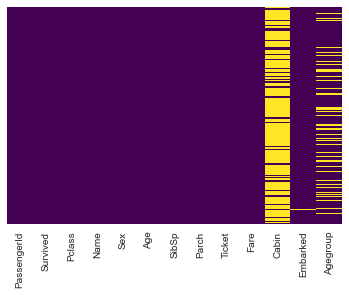

In [16]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Cleaning the data

Cleaning the data is not only filling in the values, but also remove values that we cannot use.

In [17]:
df.drop(['Cabin', 'Agegroup'], axis=1, inplace=True)
df.dropna(inplace=True)

The second step is to take care of categorical figures. We want to convert categorical features in what is known as a **dummy variable** using Pandas. Otherwise, our machine learning algorithm won't be able to take in those features as inputs.

For example, the `Sex` column is either `male` or `female`. But Machine learning algorithms don't understand the meaning of strings.<br/>Luckily, it is easy to create a numeric value representing the category. Male would be equal to 0 and Female to 1.

This is what is called dummy variable.

We will have to do the same for the Embarked column.

In [18]:
pd.get_dummies(df['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


As we can see, our Machine Learning algorithm will be able to predict perfectly that if the column `female` is equal to 0, then the `male` column will be equal to 1.

This problem is known as multi-colinearity and it will mess up the algorithm. that's why we drop one column:

In [19]:
pd.get_dummies(df['Sex'], drop_first=True)

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


Let's save the variable and do the same for the embarked column.

In [20]:
sex = pd.get_dummies(df['Sex'], drop_first=True)
embark = pd.get_dummies(df['Embarked'], drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


Now, let's add those new columns to our dataframes.

In [21]:
train = pd.concat([df, sex, embark], axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [22]:
train.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], inplace=True, axis=1)

In [23]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Creating predictions

### Create the Model and train-test split

In [24]:
x = train.drop('Survived', axis=1)
y = train['Survived']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x,                # Feature data
    y,                # Target data
    test_size=0.3,    # Percentage of data that will be allocated to the test dataset
    random_state=101  # Randomness of selection of data allocated to the test dataset
)

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

### Make predictions

In [28]:
predictions = logmodel.predict(X_test)

### Evaluate the  model

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       163
           1       0.85      0.70      0.77       104

    accuracy                           0.84       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.84      0.84      0.83       267



In [31]:
confusion_matrix(y_test, predictions)

array([[150,  13],
       [ 31,  73]])

## Making predictions from new dataset

In [32]:
# Create the test data
test = pd.read_csv('titanic_test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<AxesSubplot:>

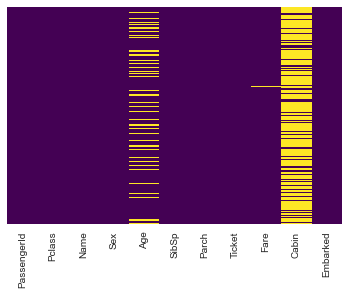

In [33]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:>

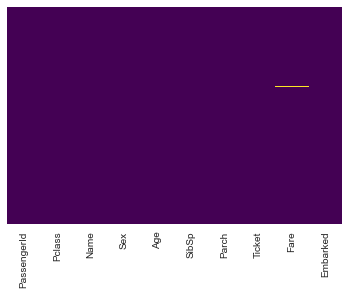

In [34]:
def impute_age_test(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        return int(test[test['Pclass'] == pclass]['Age'].mean())
    else:
        return age

test['Age'] = test[['Age', 'Pclass']].apply(impute_age_test, axis=1)
test.drop('Cabin', axis=1, inplace=True)
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [35]:
test.dropna(inplace=True)

In [36]:
test_sex = pd.get_dummies(test['Sex'], drop_first=True)
test_embark = pd.get_dummies(test['Embarked'], drop_first=True)

test = pd.concat([test, test_sex, test_embark], axis=1)
test.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], inplace=True, axis=1)

<AxesSubplot:>

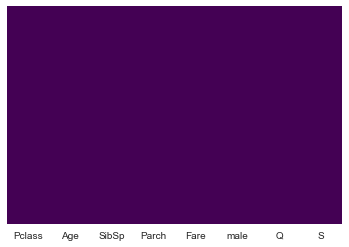

In [37]:
sns.heatmap(test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [38]:
pred_new = logmodel.predict(test)

In [44]:
print(len(pred_new))
print(test.info())

417
<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  417 non-null    int64  
 1   Age     417 non-null    float64
 2   SibSp   417 non-null    int64  
 3   Parch   417 non-null    int64  
 4   Fare    417 non-null    float64
 5   male    417 non-null    uint8  
 6   Q       417 non-null    uint8  
 7   S       417 non-null    uint8  
dtypes: float64(2), int64(3), uint8(3)
memory usage: 36.9 KB
None


<AxesSubplot:>

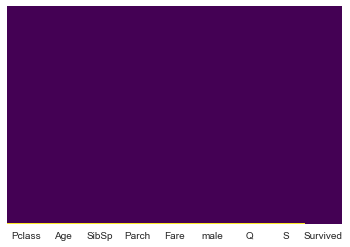

In [45]:
result = pd.concat([test, pd.DataFrame(pred_new, columns=['Survived'])], axis=1)
sns.heatmap(result.isnull(), yticklabels=False, cbar=False, cmap='viridis')